# Tesla Stock Analysis

### Getting Data

In [356]:
import pandas as pd

# Load data
tesla = pd.read_csv("TSLA_5_Minutes.csv")

# Combine 'Date' and 'Time' into a datetime column
tesla['Datetime'] = pd.to_datetime(tesla['Date'] + ' ' + tesla['Time'], dayfirst=True)

# Filter to desired date range (inclusive)
start_date = pd.to_datetime('2018-09-06')
end_date = pd.to_datetime('2019-09-06')

tesla = tesla[(tesla['Datetime'] >= start_date) & (tesla['Datetime'] <= end_date)]

# Optional: set datetime as index for time-series ops
tesla = tesla.set_index('Datetime')

print(tesla)


                       Open    High     Low   Close  Volume        Date  \
Datetime                                                                  
2018-09-06 09:35:00  284.73  288.97  284.49  285.85  476012  06-09-2018   
2018-09-06 09:40:00  285.69  287.38  284.74  287.23  152800  06-09-2018   
2018-09-06 09:45:00  287.32  287.95  285.76  287.95  105522  06-09-2018   
2018-09-06 09:50:00  287.97  290.18  287.81  289.12  236091  06-09-2018   
2018-09-06 09:55:00  289.25  291.17  288.50  290.18  190237  06-09-2018   
...                     ...     ...     ...     ...     ...         ...   
2019-09-05 15:40:00  229.62  229.63  229.12  229.38   46802  05-09-2019   
2019-09-05 15:45:00  229.33  229.38  229.01  229.18   57853  05-09-2019   
2019-09-05 15:50:00  229.16  229.38  229.07  229.30   44017  05-09-2019   
2019-09-05 15:55:00  229.26  229.47  229.10  229.47   71305  05-09-2019   
2019-09-05 16:00:00  229.41  229.75  229.31  229.48  275751  05-09-2019   

                        

In [357]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

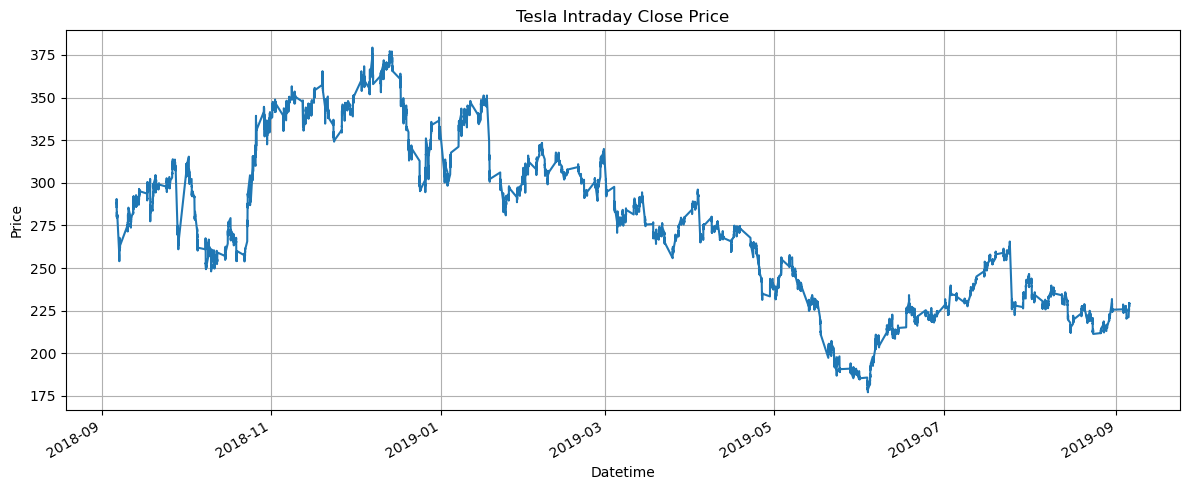

In [358]:
tesla['Close'].plot(figsize=(12, 5), title="Tesla Intraday Close Price")
plt.xlabel("Datetime")
plt.ylabel("Price")
plt.grid(True)
plt.tight_layout()
plt.show()

### Simple buy at open and sell at close trading strategy

In [362]:
# After (Correct)
tesla['Datetime'] = pd.to_datetime(tesla['Date'] + ' ' + tesla['Time'], dayfirst=True)
tesla = tesla.set_index('Datetime')

# --- Strategy Implementation ---
# Resample the 5-minute data to a daily frequency ('D')
# 'first' gets the first value of the day (the open)
# 'last' gets the last value of the day (the close)
daily_trades = tesla['Open'].resample('D').first().to_frame(name='Day_Open')
daily_trades['Day_Close'] = tesla['Close'].resample('D').last()

# Drop days where the market was closed (no trades)
daily_trades.dropna(inplace=True)

# Calculate the daily and cumulative Profit and Loss (PnL) for one share
daily_trades['PnL'] = daily_trades['Day_Close'] - daily_trades['Day_Open']
daily_trades['Cumulative_PnL'] = daily_trades['PnL'].cumsum()

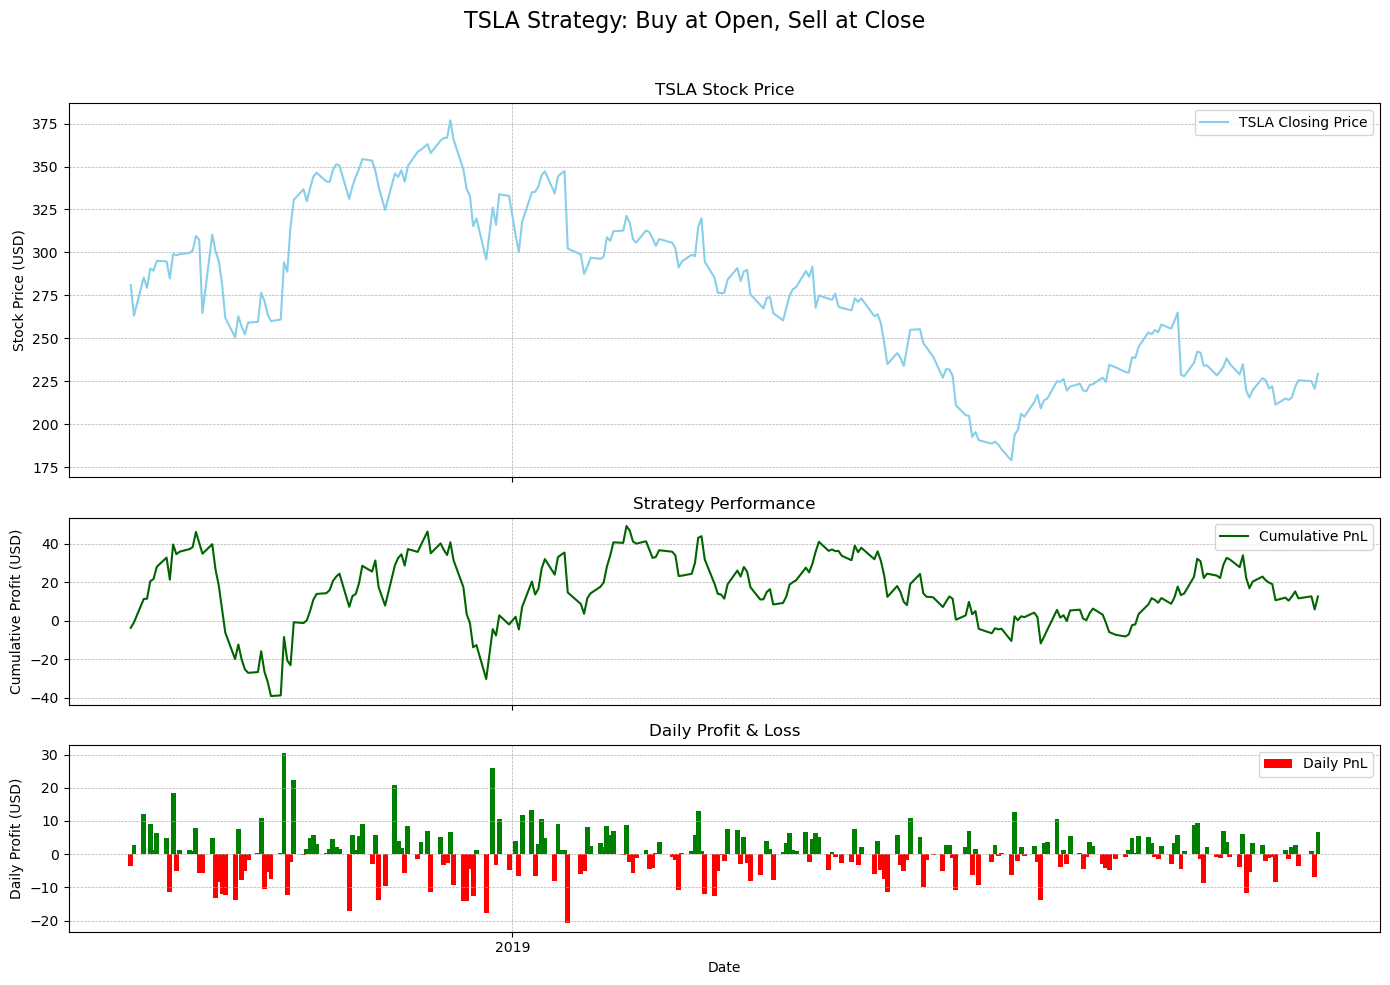

In [363]:
# --- Plotting ---
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 10), sharex=True,
                                    gridspec_kw={'height_ratios': [2, 1, 1]})
fig.suptitle('TSLA Strategy: Buy at Open, Sell at Close', fontsize=16)

# Panel 1: Stock Price
ax1.plot(daily_trades.index, daily_trades['Day_Close'], label='TSLA Closing Price', color='skyblue')
ax1.set_ylabel('Stock Price (USD)')
ax1.set_title('TSLA Stock Price')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
ax1.legend()

# Panel 2: Cumulative PnL
ax2.plot(daily_trades.index, daily_trades['Cumulative_PnL'], label='Cumulative PnL', color='darkgreen')
ax2.set_ylabel('Cumulative Profit (USD)')
ax2.set_title('Strategy Performance')
ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
ax2.legend()

# Panel 3: Daily PnL
colors = ['g' if x > 0 else 'r' for x in daily_trades['PnL']]
ax3.bar(daily_trades.index, daily_trades['PnL'], color=colors, label='Daily PnL', width=1.5)
ax3.set_ylabel('Daily Profit (USD)')
ax3.set_title('Daily Profit & Loss')
ax3.grid(True, which='both', linestyle='--', linewidth=0.5)
ax3.legend()

# Improve x-axis formatting
ax3.xaxis.set_major_locator(mdates.YearLocator())
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel('Date')

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Buy or sell when certain price deviation happens close at the end of the day. 

In [365]:
# Prepare the datetime index
tesla['Datetime'] = pd.to_datetime(tesla['Date'] + ' ' + tesla['Time'], dayfirst=True)
tesla = tesla.set_index('Datetime')

# Group data by day
grouped = tesla.groupby(tesla.index.date)

# Store daily trades
trade_results = []

for date, group in grouped:
    group = group.sort_index()  # Ensure chronological order
    
    day_open = group.iloc[0]['Open']
    day_close = group.iloc[-1]['Close']
    threshold_price = day_open * 1.005  # 0.5% increase
    
    # Look for first price that crosses threshold
    crossed = group[group['High'] >= threshold_price]
    
    if not crossed.empty:
        # Buy triggered at first threshold cross
        buy_time = crossed.index[0]
        buy_price = day_open  # As per your rule, buy at open if threshold is met later
        sell_price = day_close  # Sell at day close
        
        pnl = sell_price - buy_price
    else:
        # No trade that day
        pnl = 0.0
    
    trade_results.append({
        'Date': pd.to_datetime(date),
        'Day_Open': day_open,
        'Day_Close': day_close,
        'PnL': pnl
    })

# Convert to DataFrame
daily_trades = pd.DataFrame(trade_results)
daily_trades.set_index('Date', inplace=True)
daily_trades['Cumulative_PnL'] = daily_trades['PnL'].cumsum()

# Inspect result
print(daily_trades.head())

            Day_Open  Day_Close    PnL  Cumulative_PnL
Date                                                  
2018-09-06    284.73     281.01  -3.72           -3.72
2018-09-07    260.40     263.24   2.84           -0.88
2018-09-10    273.26     285.46  12.20           11.32
2018-09-11    279.31     279.43   0.12           11.44
2018-09-12    281.44     290.56   9.12           20.56


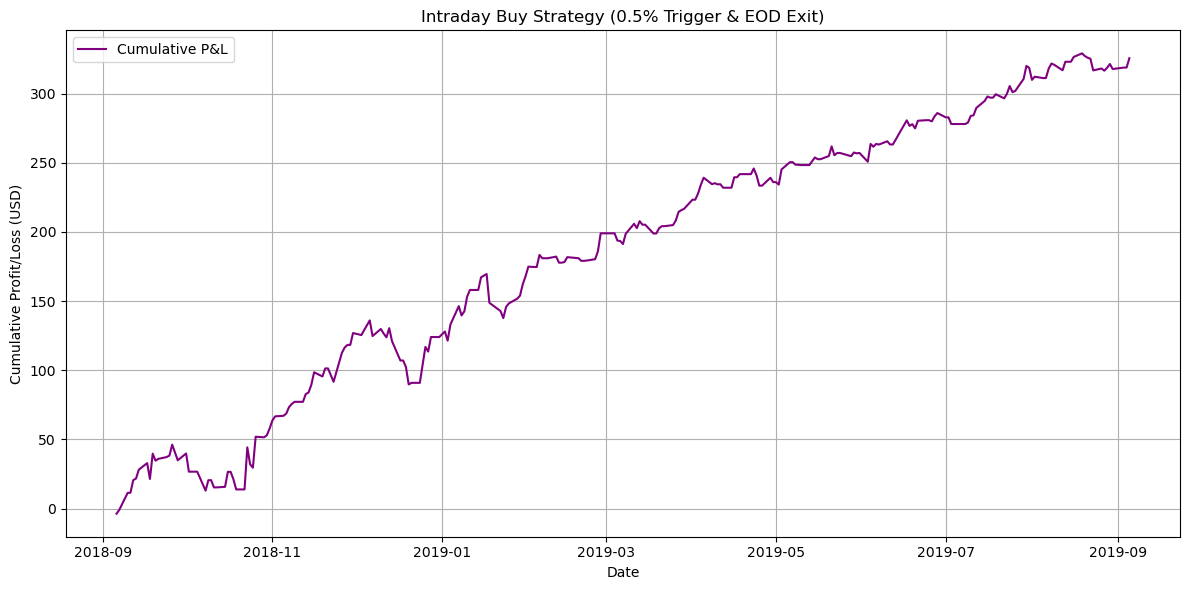

In [367]:
plt.figure(figsize=(12, 6))
plt.plot(daily_trades.index, daily_trades['Cumulative_PnL'], label='Cumulative P&L', color='purple')
plt.title('Intraday Buy Strategy (0.5% Trigger & EOD Exit)')
plt.xlabel('Date')
plt.ylabel('Cumulative Profit/Loss (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [368]:
trade_days = daily_trades[daily_trades['PnL'] != 0]

print(f"Total Profit/Loss: ${trade_days['PnL'].sum():.2f}")
print(f"Average Trade PnL: ${trade_days['PnL'].mean():.2f}")
print(f"Number of Trades: {len(trade_days)}")
print(f"Winning Trades: {(trade_days['PnL'] > 0).sum()}")
print(f"Losing Trades: {(trade_days['PnL'] < 0).sum()}")

Total Profit/Loss: $325.49
Average Trade PnL: $1.56
Number of Trades: 208
Winning Trades: 131
Losing Trades: 77


### Adjusted conditional strategy with buy fix and stop loss

In [370]:
threshold = 0.7      # % move to trigger entry
stop_loss_pct = 1.5  # % stop loss
tesla["Position"] = "None"
tesla["PnL"] = 0.0

# Group by trading day
grouped = tesla.groupby(tesla.index.date)

for date, group in grouped:
    group = group.sort_index()
    day_open = group.iloc[0]['Open']
    threshold_price_up = day_open * (1 + threshold / 100)
    threshold_price_down = day_open * (1 - threshold / 100)
    
    stop_loss_long = day_open * (1 - stop_loss_pct / 100)
    stop_loss_short = day_open * (1 + stop_loss_pct / 100)

    trade_triggered = False

    for i in range(len(group)):
        current = group.iloc[i]
        idx = group.index[i]
        
        # ----- Long trade -----
        if not trade_triggered and current['High'] >= threshold_price_up:
            trade_triggered = True
            tesla.at[idx, 'Position'] = 'Long'
            
            # Look forward to simulate stop-loss or close
            for j in range(i, len(group)):
                forward = group.iloc[j]
                forward_idx = group.index[j]
                
                if forward['Low'] <= stop_loss_long:
                    # Stop loss hit
                    stop_price = stop_loss_long
                    pnl = stop_price - day_open
                    tesla.at[idx, 'PnL'] = pnl
                    break
            else:
                # No stop loss hit, exit at close of day
                final_close = group.iloc[-1]['Close']
                pnl = final_close - day_open
                tesla.at[idx, 'PnL'] = pnl
            break  # only one trade per day
        
        # ----- Short trade -----
        elif not trade_triggered and current['Low'] <= threshold_price_down:
            trade_triggered = True
            tesla.at[idx, 'Position'] = 'Short'
            
            for j in range(i, len(group)):
                forward = group.iloc[j]
                forward_idx = group.index[j]
                
                if forward['High'] >= stop_loss_short:
                    stop_price = stop_loss_short
                    pnl = day_open - stop_price
                    tesla.at[idx, 'PnL'] = pnl
                    break
            else:
                final_close = group.iloc[-1]['Close']
                pnl = day_open - final_close
                tesla.at[idx, 'PnL'] = pnl
            break

# Compute return and cumulative PnL
tesla['ReturnPctTrade'] = tesla['PnL'] / tesla['Open'] * 100
tesla['Cumulative_PnL'] = tesla['PnL'].cumsum()

In [372]:
trade_entries = tesla[tesla['Position'] != 'None'].copy()

trade_entries['Trade_Date'] = trade_entries.index.date
daily_summary = trade_entries.groupby('Trade_Date').agg({
    'PnL': 'sum'  # Only one trade per day in current strategy
})
daily_summary['Cumulative_PnL'] = daily_summary['PnL'].cumsum()

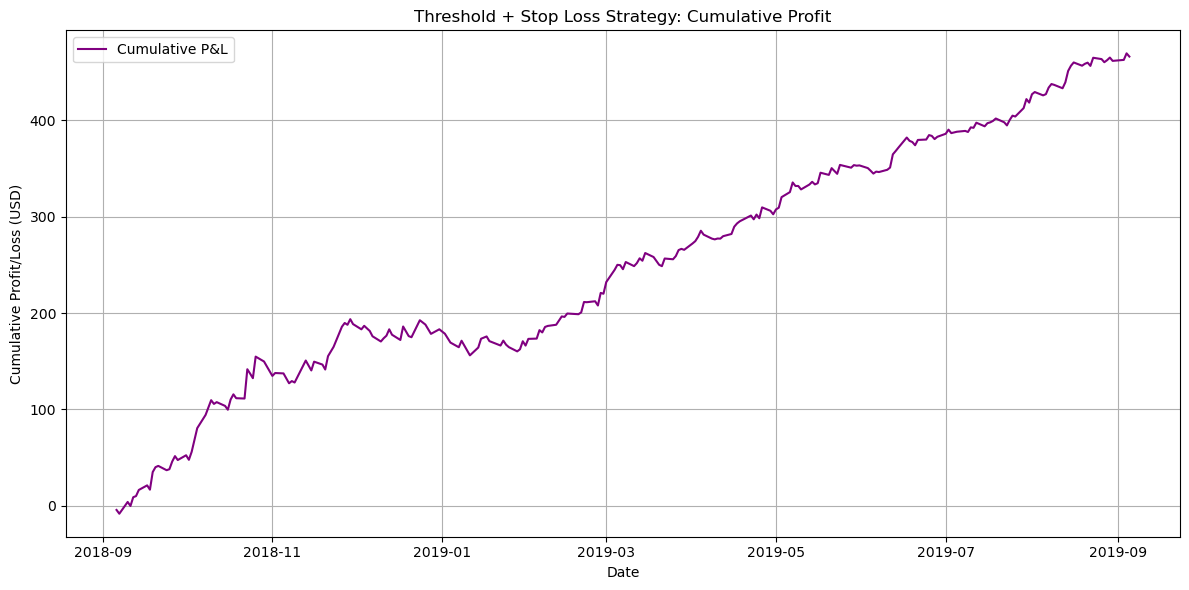

In [373]:
plt.figure(figsize=(12, 6))
plt.plot(daily_summary.index, daily_summary['Cumulative_PnL'], color='purple', label='Cumulative P&L')
plt.title('Threshold + Stop Loss Strategy: Cumulative Profit')
plt.xlabel('Date')
plt.ylabel('Cumulative Profit/Loss (USD)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [374]:
trades = tesla[tesla['Position'] != 'None']

In [375]:
print(f"Total Profit/Loss: ${tesla['PnL'].sum():.2f}")
print(f"Average Trade PnL: ${tesla.loc[tesla['Position'] != 'None', 'PnL'].mean():.2f}")
print(f"Average Percent Return per Trade: {trades['ReturnPctTrade'].mean():.4f}%")
print(f"Max Return: {trades['ReturnPctTrade'].max():.2f}%")
print(f"Min Return: {trades['ReturnPctTrade'].min():.2f}%")
print(f"Number of Trades: {(tesla['Position'] != 'None').sum()}")
print(f"Winning Trades: {(tesla['PnL'] > 0).sum()}")
print(f"Losing Trades: {(tesla['PnL'] < 0).sum()}")

Total Profit/Loss: $466.25
Average Trade PnL: $1.86
Average Percent Return per Trade: 0.6996%
Max Return: 11.52%
Min Return: -1.51%
Number of Trades: 251
Winning Trades: 140
Losing Trades: 111


### Strategies performance vs buy and hold

In [377]:
total_profit = tesla.loc[tesla['Position'] != 'None', 'PnL'].sum()

In [378]:
# Total capital used (sum of open prices on trade days, 1 share per trade)
total_cost = tesla.loc[tesla['Position'] != 'None', 'Open'].sum()
total_return_pct = (total_profit / total_cost) * 100

In [379]:
# Buy first candle, hold until last candle
first_price = tesla.iloc[0]['Open']
last_price = tesla.iloc[-1]['Close']

buy_and_hold_profit = last_price - first_price
buy_and_hold_return_pct = (buy_and_hold_profit / first_price) * 100

In [380]:
# Strategy return
trades = tesla[tesla['Position'] != 'None']
total_profit = trades['PnL'].sum()
total_cost = trades['Open'].sum()
total_return_pct = (total_profit / total_cost) * 100

# Buy-and-hold return
first_price = tesla.iloc[0]['Open']
last_price = tesla.iloc[-1]['Close']
buy_and_hold_profit = last_price - first_price
buy_and_hold_return_pct = (buy_and_hold_profit / first_price) * 100
buy_and_hold_cost = first_price  # capital deployed in B&H (1 share)

# Print summary
print("=== Strategy Performance ===")
print(f"Total Profit from Strategy: ${total_profit:.2f}")
print(f"Total Capital Deployed: ${total_cost:.2f}")
print(f"Total Return (Strategy): {total_return_pct:.2f}%")

print("\n=== Buy & Hold Performance ===")
print(f"Total Profit from Buy & Hold: ${buy_and_hold_profit:.2f}")
print(f"Capital Deployed (Buy & Hold): ${buy_and_hold_cost:.2f}")
print(f"Total Return (Buy & Hold): {buy_and_hold_return_pct:.2f}%")


=== Strategy Performance ===
Total Profit from Strategy: $466.25
Total Capital Deployed: $69275.11
Total Return (Strategy): 0.67%

=== Buy & Hold Performance ===
Total Profit from Buy & Hold: $-55.25
Capital Deployed (Buy & Hold): $284.73
Total Return (Buy & Hold): -19.40%


### Adding take profit logic

In [382]:
threshold = 0.6        # % move to trigger trade
stop_loss_pct = 1.0    # % stop loss
take_profit_pct = 5.0  # % take profit

# Reset
tesla["Position"] = "None"
tesla["PnL"] = 0.0

# Group by trading day
grouped = tesla.groupby(tesla.index.date)

for date, group in grouped:
    group = group.sort_index()
    day_open = group.iloc[0]['Open']
    
    # Entry thresholds
    threshold_up = day_open * (1 + threshold / 100)
    threshold_down = day_open * (1 - threshold / 100)
    
    # SL and TP levels
    sl_long = day_open * (1 - stop_loss_pct / 100)
    tp_long = day_open * (1 + take_profit_pct / 100)
    
    sl_short = day_open * (1 + stop_loss_pct / 100)
    tp_short = day_open * (1 - take_profit_pct / 100)
    
    trade_triggered = False

    for i in range(len(group)):
        current = group.iloc[i]
        idx = group.index[i]
        
        # Long entry
        if not trade_triggered and current['High'] >= threshold_up:
            tesla.at[idx, 'Position'] = 'Long'
            trade_triggered = True
            
            for j in range(i, len(group)):
                forward = group.iloc[j]
                
                # Hit Stop-Loss
                if forward['Low'] <= sl_long:
                    tesla.at[idx, 'PnL'] = sl_long - day_open
                    break
                # Hit Take-Profit
                elif forward['High'] >= tp_long:
                    tesla.at[idx, 'PnL'] = tp_long - day_open
                    break
            else:
                # Exit at end-of-day close
                final_close = group.iloc[-1]['Close']
                tesla.at[idx, 'PnL'] = final_close - day_open
            break  # one trade per day

        # Short entry
        elif not trade_triggered and current['Low'] <= threshold_down:
            tesla.at[idx, 'Position'] = 'Short'
            trade_triggered = True

            for j in range(i, len(group)):
                forward = group.iloc[j]
                
                if forward['High'] >= sl_short:
                    tesla.at[idx, 'PnL'] = day_open - sl_short
                    break
                elif forward['Low'] <= tp_short:
                    tesla.at[idx, 'PnL'] = day_open - tp_short
                    break
            else:
                final_close = group.iloc[-1]['Close']
                tesla.at[idx, 'PnL'] = day_open - final_close
            break


In [383]:
tesla['Cumulative_PnL'] = tesla['PnL'].cumsum()
tesla['ReturnPctTrade'] = tesla['PnL'] / tesla['Open'] * 100
trades = tesla[tesla['Position'] != 'None']

# Metrics
print(f"Total Profit: ${trades['PnL'].sum():.2f}")
print(f"Average % Return per Trade: {trades['ReturnPctTrade'].mean():.2f}%")
print(f"Winning Trades: {(trades['PnL'] > 0).sum()}")
print(f"Losing Trades: {(trades['PnL'] < 0).sum()}")


Total Profit: $446.15
Average % Return per Trade: 0.67%
Winning Trades: 123
Losing Trades: 128


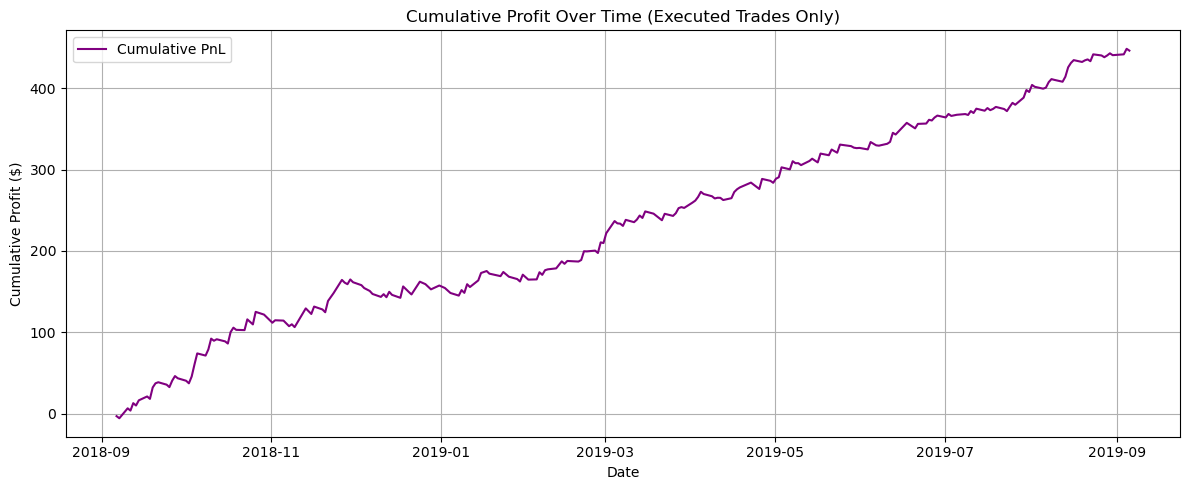

In [384]:
plt.figure(figsize=(12, 5))
plt.plot(trades.index, trades['PnL'].cumsum(), label='Cumulative PnL', color='purple')
plt.title('Cumulative Profit Over Time (Executed Trades Only)')
plt.xlabel('Date')
plt.ylabel('Cumulative Profit ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Add trading cost to the strategy

In [387]:
threshold = 2.1       # % move to trigger trade
stop_loss_pct = 1.0    # % stop loss
take_profit_pct = 8.0  # % take profit
trading_cost = 0.30

# Reset
tesla["Position"] = "None"
tesla["PnL"] = 0.0

# Group by trading day
grouped = tesla.groupby(tesla.index.date)

for date, group in grouped:
    group = group.sort_index()
    day_open = group.iloc[0]['Open']
    
    # Entry thresholds
    threshold_up = day_open * (1 + threshold / 100)
    threshold_down = day_open * (1 - threshold / 100)
    
    # SL and TP levels
    sl_long = day_open * (1 - stop_loss_pct / 100)
    tp_long = day_open * (1 + take_profit_pct / 100)
    
    sl_short = day_open * (1 + stop_loss_pct / 100)
    tp_short = day_open * (1 - take_profit_pct / 100)
    
    trade_triggered = False

    for i in range(len(group)):
        current = group.iloc[i]
        idx = group.index[i]
        
        # Long entry
        if not trade_triggered and current['High'] >= threshold_up:
            tesla.at[idx, 'Position'] = 'Long'
            trade_triggered = True
            
            for j in range(i, len(group)):
                forward = group.iloc[j]
                
                # Hit Stop-Loss
                if forward['Low'] <= sl_long:
                    tesla.at[idx, 'PnL'] = sl_long - day_open - trading_cost
                    break
                # Hit Take-Profit
                elif forward['High'] >= tp_long:
                    tesla.at[idx, 'PnL'] = tp_long - day_open - trading_cost
                    break
            else:
                # Exit at end-of-day close
                final_close = group.iloc[-1]['Close']
                tesla.at[idx, 'PnL'] = final_close - day_open - trading_cost
            break  # one trade per day

        # Short entry
        elif not trade_triggered and current['Low'] <= threshold_down:
            tesla.at[idx, 'Position'] = 'Short'
            trade_triggered = True

            for j in range(i, len(group)):
                forward = group.iloc[j]
                
                if forward['High'] >= sl_short:
                    tesla.at[idx, 'PnL'] = day_open - sl_short - trading_cost
                    break
                elif forward['Low'] <= tp_short:
                    tesla.at[idx, 'PnL'] = day_open - tp_short - trading_cost
                    break
            else:
                final_close = group.iloc[-1]['Close']
                tesla.at[idx, 'PnL'] = day_open - final_close - trading_cost
            break


In [388]:
tesla['Cumulative_PnL'] = tesla['PnL'].cumsum()
tesla['ReturnPctTrade'] = tesla['PnL'] / tesla['Open'] * 100
trades = tesla[tesla['Position'] != 'None']

# Metrics
print(f"Total Profit: ${trades['PnL'].sum():.2f}")
print(f"Average % Return per Trade: {trades['ReturnPctTrade'].mean():.2f}%")
print(f"Winning Trades: {(trades['PnL'] > 0).sum()}")
print(f"Losing Trades: {(trades['PnL'] < 0).sum()}")

Total Profit: $919.78
Average % Return per Trade: 1.97%
Winning Trades: 138
Losing Trades: 31


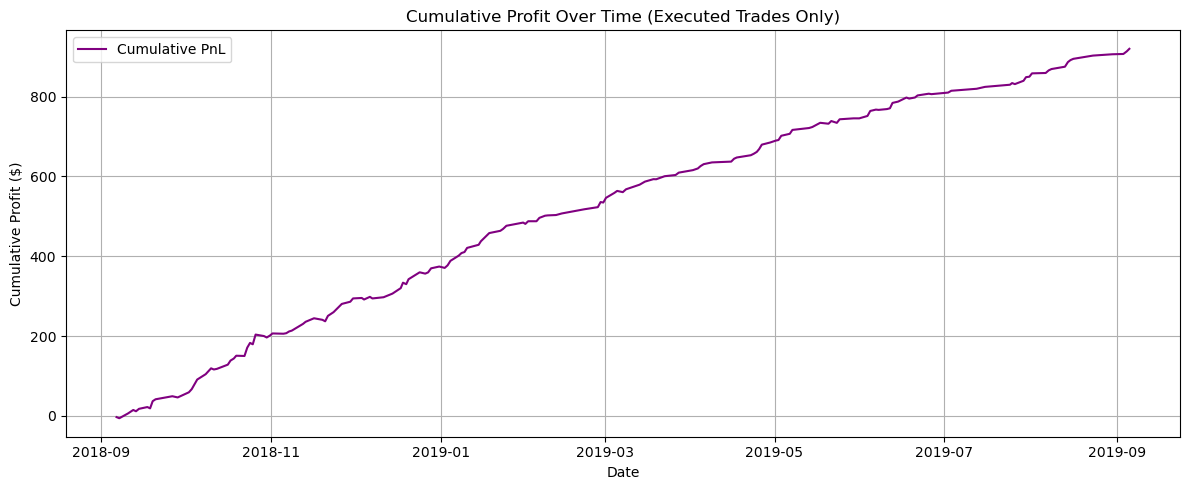

In [389]:
plt.figure(figsize=(12, 5))
plt.plot(trades.index, trades['PnL'].cumsum(), label='Cumulative PnL', color='purple')
plt.title('Cumulative Profit Over Time (Executed Trades Only)')
plt.xlabel('Date')
plt.ylabel('Cumulative Profit ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

************************************************************

### Adding EMA & SMA average into the strategy

In [393]:
threshold = 1.0 # % move to trigger trade
stop_loss_pct = 2.0
take_profit_pct = 10.0
trading_cost = 0.30

# Add EMA before looping
tesla['EMA20'] = tesla['Close'].ewm(span=20, adjust=False).mean()

# Reset columns for the backtest
tesla["Position"] = "None"
tesla["PnL"] = 0.0

# Group data by day
grouped = tesla.groupby(tesla.index.date)

# --- Main Backtest Loop ---
for date, group in grouped:
    group = group.sort_index()
    day_open = group.iloc[0]['Open']

    # Define price levels for the day
    threshold_up = day_open * (1 + threshold / 100)
    threshold_down = day_open * (1 - threshold / 100)
    
    sl_long = day_open * (1 - stop_loss_pct / 100)
    tp_long = day_open * (1 + take_profit_pct / 100)
    
    sl_short = day_open * (1 + stop_loss_pct / 100)
    tp_short = day_open * (1 - take_profit_pct / 100)

    trade_triggered = False

    # Loop through each 5-minute bar of the day
    for i in range(len(group)):
        current = group.iloc[i]
        idx = group.index[i]

        # --- Long Entry with EMA filter ---
        if (
            not trade_triggered and
            current['High'] >= threshold_up and
            current['Close'] > current['EMA20']
        ):
            tesla.at[idx, 'Position'] = 'Long'
            trade_triggered = True

            # Look forward from entry to find exit
            for j in range(i, len(group)):
                forward = group.iloc[j]
                # Stop-Loss Hit
                if forward['Low'] <= sl_long:
                    # CORRECTED PNL CALCULATION
                    tesla.at[idx, 'PnL'] = sl_long - threshold_up - trading_cost
                    break
                # Take-Profit Hit
                elif forward['High'] >= tp_long:
                    # CORRECTED PNL CALCULATION
                    tesla.at[idx, 'PnL'] = tp_long - threshold_up - trading_cost
                    break
            # If loop finishes (no SL/TP), exit at end of day
            else:
                final_close = group.iloc[-1]['Close']
                # CORRECTED PNL CALCULATION
                tesla.at[idx, 'PnL'] = final_close - threshold_up - trading_cost
            break # Exit inner loop once trade is done

        # --- Short Entry with EMA filter ---
        elif (
            not trade_triggered and
            current['Low'] <= threshold_down and
            current['Close'] < current['EMA20']
        ):
            tesla.at[idx, 'Position'] = 'Short'
            trade_triggered = True
            
            # Look forward from entry to find exit
            for j in range(i, len(group)):
                forward = group.iloc[j]
                # Stop-Loss Hit
                if forward['High'] >= sl_short:
                    # CORRECTED PNL CALCULATION
                    tesla.at[idx, 'PnL'] = threshold_down - sl_short - trading_cost
                    break
                # Take-Profit Hit
                elif forward['Low'] <= tp_short:
                    # CORRECTED PNL CALCULATION
                    tesla.at[idx, 'PnL'] = threshold_down - tp_short - trading_cost
                    break
            # If loop finishes (no SL/TP), exit at end of day
            else:
                final_close = group.iloc[-1]['Close']
                # CORRECTED PNL CALCULATION
                tesla.at[idx, 'PnL'] = threshold_down - final_close - trading_cost
            break # Exit inner loop once trade is done


In [396]:
tesla['Cumulative_PnL'] = tesla['PnL'].cumsum()
tesla['ReturnPctTrade'] = tesla['PnL'] / tesla['Open'] * 100
trades = tesla[tesla['Position'] != 'None']

# Metrics
print(f"Total Profit: ${trades['PnL'].sum():.2f}")
print(f"Average % Return per Trade: {trades['ReturnPctTrade'].mean():.2f}%")
print(f"Winning Trades: {(trades['PnL'] > 0).sum()}")
print(f"Losing Trades: {(trades['PnL'] < 0).sum()}")

Total Profit: $26.04
Average % Return per Trade: 0.05%
Winning Trades: 120
Losing Trades: 127


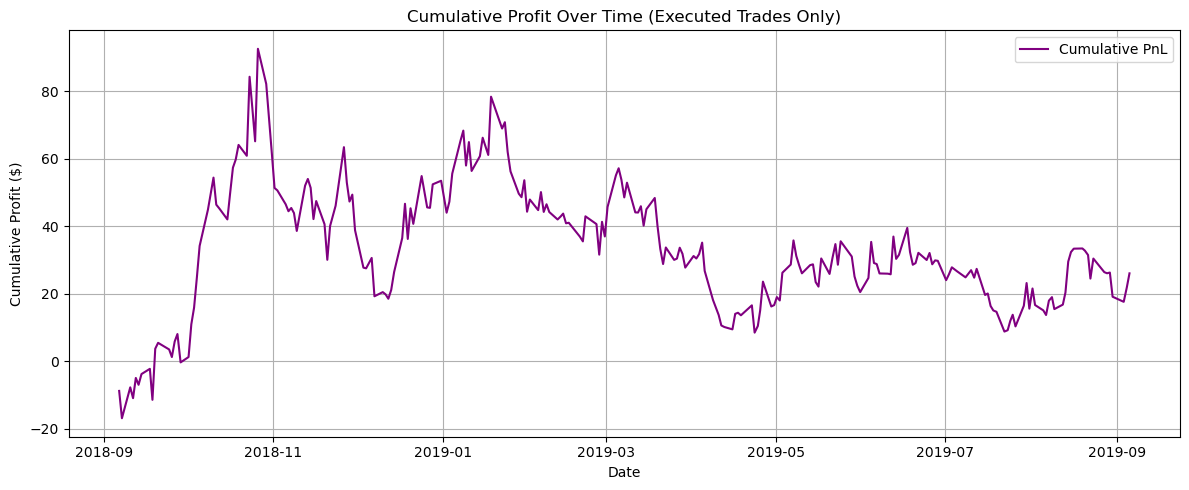

In [397]:
plt.figure(figsize=(12, 5))
plt.plot(trades.index, trades['PnL'].cumsum(), label='Cumulative PnL', color='purple')
plt.title('Cumulative Profit Over Time (Executed Trades Only)')
plt.xlabel('Date')
plt.ylabel('Cumulative Profit ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Final enhancments for the EML/SML strategy 

In [399]:
threshold = 2.1       # % move to trigger trade
stop_loss_pct = 1.0
take_profit_pct = 8.0
trading_cost = 0.30

# Add EMA before looping
tesla['EMA20'] = tesla['Close'].ewm(span=20).mean()

# Reset
tesla["Position"] = "None"
tesla["PnL"] = 0.0

grouped = tesla.groupby(tesla.index.date)

for date, group in grouped:
    group = group.sort_index()
    day_open = group.iloc[0]['Open']

    threshold_up = day_open * (1 + threshold / 100)
    threshold_down = day_open * (1 - threshold / 100)
    
    sl_long = day_open * (1 - stop_loss_pct / 100)
    tp_long = day_open * (1 + take_profit_pct / 100)
    
    sl_short = day_open * (1 + stop_loss_pct / 100)
    tp_short = day_open * (1 - take_profit_pct / 100)

    trade_triggered = False

    for i in range(len(group)):
        current = group.iloc[i]
        idx = group.index[i]

        # Long entry with EMA filter
        if (
            not trade_triggered and
            current['High'] >= threshold_up and
            current['Close'] > current['EMA20']
        ):
            tesla.at[idx, 'Position'] = 'Long'
            trade_triggered = True

            for j in range(i, len(group)):
                forward = group.iloc[j]
                if forward['Low'] <= sl_long:
                    tesla.at[idx, 'PnL'] = sl_long - day_open - trading_cost
                    break
                elif forward['High'] >= tp_long:
                    tesla.at[idx, 'PnL'] = tp_long - day_open - trading_cost
                    break
            else:
                final_close = group.iloc[-1]['Close']
                tesla.at[idx, 'PnL'] = final_close - day_open - trading_cost
            break

        # Short entry with EMA filter
        elif (
            not trade_triggered and
            current['Low'] <= threshold_down and
            current['Close'] < current['EMA20']
        ):
            tesla.at[idx, 'Position'] = 'Short'
            trade_triggered = True

            for j in range(i, len(group)):
                forward = group.iloc[j]
                if forward['High'] >= sl_short:
                    tesla.at[idx, 'PnL'] = day_open - sl_short - trading_cost
                    break
                elif forward['Low'] <= tp_short:
                    tesla.at[idx, 'PnL'] = day_open - tp_short - trading_cost
                    break
            else:
                final_close = group.iloc[-1]['Close']
                tesla.at[idx, 'PnL'] = day_open - final_close - trading_cost
            break


In [400]:
tesla['Cumulative_PnL'] = tesla['PnL'].cumsum()
tesla['ReturnPctTrade'] = tesla['PnL'] / tesla['Open'] * 100
trades = tesla[tesla['Position'] != 'None']

# Metrics
print(f"Total Profit: ${trades['PnL'].sum():.2f}")
print(f"Average % Return per Trade: {trades['ReturnPctTrade'].mean():.2f}%")
print(f"Winning Trades: {(trades['PnL'] > 0).sum()}")
print(f"Losing Trades: {(trades['PnL'] < 0).sum()}")

Total Profit: $942.22
Average % Return per Trade: 2.03%
Winning Trades: 141
Losing Trades: 28


In [401]:
# --- Strategy Parameters ---
threshold = 1.1  # % move to trigger trade
stop_loss_pct = 2.5
take_profit_pct = 10.0
trading_cost = 0.30  # flat cost (assumes per share or round trip)
slippage_pct = 0.1 / 100  # optional slippage as a fraction

# --- Compute EMA ---
tesla['EMA20'] = tesla['Close'].ewm(span=20, adjust=False).mean()

# --- Initialize trade log ---
trades = []

# --- Group data by day ---
grouped = tesla.groupby(tesla.index.date)

# --- Backtest Loop ---
for date, group in grouped:
    group = group.sort_index()
    day_open = group.iloc[0]['Open']

    threshold_up = day_open * (1 + threshold / 100)
    threshold_down = day_open * (1 - threshold / 100)

    trade_triggered = False

    for i in range(len(group)):
        current = group.iloc[i]
        idx = group.index[i]

        # --- Long Entry Condition ---
        if (
            not trade_triggered and
            current['High'] >= threshold_up and
            current['Close'] > current['EMA20']
        ):
            entry_price = current['Close']
            entry_time = idx

            sl_price = entry_price * (1 - stop_loss_pct / 100)
            tp_price = entry_price * (1 + take_profit_pct / 100)

            # Check exit conditions
            for j in range(i, len(group)):
                forward = group.iloc[j]
                exit_time = group.index[j]

                if forward['Low'] <= sl_price * (1 - slippage_pct):
                    exit_price = sl_price * (1 - slippage_pct)
                    reason = 'Stop Loss'
                    break
                elif forward['High'] >= tp_price * (1 + slippage_pct):
                    exit_price = tp_price * (1 + slippage_pct)
                    reason = 'Take Profit'
                    break
            else:
                exit_price = group.iloc[-1]['Close']
                exit_time = group.index[-1]
                reason = 'End of Day'

            pnl = exit_price - entry_price - trading_cost

            trades.append({
                'Date': date,
                'Direction': 'Long',
                'Entry Time': entry_time,
                'Entry Price': entry_price,
                'Exit Time': exit_time,
                'Exit Price': exit_price,
                'PnL': pnl,
                'Reason': reason
            })

            trade_triggered = True
            break

        # --- Short Entry Condition ---
        elif (
            not trade_triggered and
            current['Low'] <= threshold_down and
            current['Close'] < current['EMA20']
        ):
            entry_price = current['Close']
            entry_time = idx

            sl_price = entry_price * (1 + stop_loss_pct / 100)
            tp_price = entry_price * (1 - take_profit_pct / 100)

            for j in range(i, len(group)):
                forward = group.iloc[j]
                exit_time = group.index[j]

                if forward['High'] >= sl_price * (1 + slippage_pct):
                    exit_price = sl_price * (1 + slippage_pct)
                    reason = 'Stop Loss'
                    break
                elif forward['Low'] <= tp_price * (1 - slippage_pct):
                    exit_price = tp_price * (1 - slippage_pct)
                    reason = 'Take Profit'
                    break
            else:
                exit_price = group.iloc[-1]['Close']
                exit_time = group.index[-1]
                reason = 'End of Day'

            pnl = entry_price - exit_price - trading_cost

            trades.append({
                'Date': date,
                'Direction': 'Short',
                'Entry Time': entry_time,
                'Entry Price': entry_price,
                'Exit Time': exit_time,
                'Exit Price': exit_price,
                'PnL': pnl,
                'Reason': reason
            })

            trade_triggered = True
            break

# --- Convert to DataFrame ---
trade_df = pd.DataFrame(trades)


In [402]:
trade_df['ReturnPctTrade'] = trade_df['PnL'] / trade_df['Entry Price'] * 100
trade_df['Cumulative_PnL'] = trade_df['PnL'].cumsum()

print(f"Total Profit: ${trade_df['PnL'].sum():.2f}")
print(f"Average % Return per Trade: {trade_df['ReturnPctTrade'].mean():.2f}%")
print(f"Winning Trades: {(trade_df['PnL'] > 0).sum()}")
print(f"Losing Trades: {(trade_df['PnL'] < 0).sum()}")
print(f"Win Rate: {(trade_df['PnL'] > 0).mean() * 100:.2f}%")
print(f"Total Trades: {len(trade_df)}")

Total Profit: $38.19
Average % Return per Trade: 0.04%
Winning Trades: 125
Losing Trades: 118
Win Rate: 51.44%
Total Trades: 243


*********************************************************************************************

## RSI and ATR filters to improve the strategy

In [405]:
pip install ta

Note: you may need to restart the kernel to use updated packages.


In [407]:
import ta

# --- Strategy Parameters ---
threshold = 1.8  # % move to trigger trade
stop_loss_pct = 4.5
take_profit_pct = 8.0
trading_cost = 0.30
slippage_pct = 0.1 / 100

# --- Indicators ---
tesla['EMA20'] = tesla['Close'].ewm(span=20, adjust=False).mean()
tesla['RSI'] = ta.momentum.RSIIndicator(close=tesla['Close'], window=14).rsi()
tesla['ATR'] = ta.volatility.AverageTrueRange(
    high=tesla['High'], low=tesla['Low'], close=tesla['Close'], window=14
).average_true_range()

# --- Filter Parameters ---
min_rsi_long = 55
max_rsi_short = 45
min_atr_pct = 0.005  # ATR must be > 0.5% of price

# --- Trade Logging ---
trades = []

# --- Group by Date ---
grouped = tesla.groupby(tesla.index.date)

for date, group in grouped:
    group = group.sort_index()
    day_open = group.iloc[0]['Open']

    threshold_up = day_open * (1 + threshold / 100)
    threshold_down = day_open * (1 - threshold / 100)

    trade_triggered = False

    for i in range(len(group)):
        current = group.iloc[i]
        idx = group.index[i]

        atr_ratio = current['ATR'] / current['Close']
        rsi_value = current['RSI']

        # --- Long Entry Conditions ---
        if (
            not trade_triggered
            and current['High'] >= threshold_up
            and current['Close'] > current['EMA20']
            and rsi_value > min_rsi_long
            and atr_ratio > min_atr_pct
        ):
            entry_price = current['Close']
            entry_time = idx
            sl_price = entry_price * (1 - stop_loss_pct / 100)
            tp_price = entry_price * (1 + take_profit_pct / 100)

            for j in range(i, len(group)):
                forward = group.iloc[j]
                exit_time = group.index[j]

                if forward['Low'] <= sl_price * (1 - slippage_pct):
                    exit_price = sl_price * (1 - slippage_pct)
                    reason = 'Stop Loss'
                    break
                elif forward['High'] >= tp_price * (1 + slippage_pct):
                    exit_price = tp_price * (1 + slippage_pct)
                    reason = 'Take Profit'
                    break
            else:
                exit_price = group.iloc[-1]['Close']
                exit_time = group.index[-1]
                reason = 'End of Day'

            pnl = exit_price - entry_price - trading_cost

            trades.append({
                'Date': date,
                'Direction': 'Long',
                'Entry Time': entry_time,
                'Entry Price': entry_price,
                'Exit Time': exit_time,
                'Exit Price': exit_price,
                'PnL': pnl,
                'Reason': reason
            })

            trade_triggered = True
            break

        # --- Short Entry Conditions ---
        elif (
            not trade_triggered
            and current['Low'] <= threshold_down
            and current['Close'] < current['EMA20']
            and rsi_value < max_rsi_short
            and atr_ratio > min_atr_pct
        ):
            entry_price = current['Close']
            entry_time = idx
            sl_price = entry_price * (1 + stop_loss_pct / 100)
            tp_price = entry_price * (1 - take_profit_pct / 100)

            for j in range(i, len(group)):
                forward = group.iloc[j]
                exit_time = group.index[j]

                if forward['High'] >= sl_price * (1 + slippage_pct):
                    exit_price = sl_price * (1 + slippage_pct)
                    reason = 'Stop Loss'
                    break
                elif forward['Low'] <= tp_price * (1 - slippage_pct):
                    exit_price = tp_price * (1 - slippage_pct)
                    reason = 'Take Profit'
                    break
            else:
                exit_price = group.iloc[-1]['Close']
                exit_time = group.index[-1]
                reason = 'End of Day'

            pnl = entry_price - exit_price - trading_cost

            trades.append({
                'Date': date,
                'Direction': 'Short',
                'Entry Time': entry_time,
                'Entry Price': entry_price,
                'Exit Time': exit_time,
                'Exit Price': exit_price,
                'PnL': pnl,
                'Reason': reason
            })

            trade_triggered = True
            break



In [409]:
# --- Convert to DataFrame ---
trade_df = pd.DataFrame(trades)

# --- Add Metrics ---
trade_df['ReturnPctTrade'] = trade_df['PnL'] / trade_df['Entry Price'] * 100
trade_df['Cumulative_PnL'] = trade_df['PnL'].cumsum()

# --- Print Summary Metrics ---
print(f"Total Profit: ${trade_df['PnL'].sum():.2f}")
print(f"Average % Return per Trade: {trade_df['ReturnPctTrade'].mean():.2f}%")
print(f"Winning Trades: {(trade_df['PnL'] > 0).sum()}")
print(f"Losing Trades: {(trade_df['PnL'] < 0).sum()}")
print(f"Win Rate: {(trade_df['PnL'] > 0).mean() * 100:.2f}%")
print(f"Total Trades: {len(trade_df)}")

Total Profit: $4.46
Average % Return per Trade: 0.02%
Winning Trades: 53
Losing Trades: 62
Win Rate: 46.09%
Total Trades: 115


**********************************************************************

### Added time avoidance, dynamic thresholds, Trailing stops

In [419]:
# --- Strategy Parameters ---
base_threshold = 1.2  # Base threshold (%) - adjusted by ATR
stop_loss_multiplier = 1.5  # SL = ATR * multiplier
take_profit_multiplier = 3.0  # TP = ATR * multiplier
trading_cost = 0.30  # Commission per trade
slippage_pct = 0.1 / 100  # 0.1% slippage

# --- Avoidance Filters ---
avoid_first_minutes = 30  # Skip first 30 mins
avoid_last_minutes = 30  # Skip last 30 mins
min_volume_multiplier = 1.2  # Volume must be > 20% of 10-day avg

# --- Indicators ---
def calculate_indicators(df):
    df['VWAP'] = (df['Volume'] * (df['High'] + df['Low'] + df['Close']) / 3).cumsum() / df['Volume'].cumsum()
    df['RSI'] = ta.momentum.RSIIndicator(close=df['Close'], window=14).rsi()
    df['ATR'] = ta.volatility.AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'], window=14).average_true_range()
    df['10d_avg_volume'] = df['Volume'].rolling(window=10*78).mean()  # 10 days (78 5-min bars/day)
    return df

tesla = calculate_indicators(tesla)

# --- Trade Logging ---
trades = []
grouped = tesla.groupby(tesla.index.date)

for date, group in grouped:
    group = group.sort_index()
    day_open = group.iloc[0]['Open']
    day_start = group.index[0]
    day_end = group.index[-1]
    
    # Skip if data is incomplete (e.g., half trading day)
    if len(group) < 78 * 0.8:  # <80% of expected 5-min bars
        continue
        
    for i in range(len(group)):
        current = group.iloc[i]
        current_time = group.index[i]
        
        # --- Avoidance Conditions ---
        # Skip first/last 30 mins
        if (current_time < (day_start + pd.Timedelta(minutes=avoid_first_minutes))) or \
           (current_time > (day_end - pd.Timedelta(minutes=avoid_last_minutes))):
            continue
            
        # Skip low-volume periods
        if current['Volume'] < min_volume_multiplier * current['10d_avg_volume']:
            continue
            
        # --- Dynamic Thresholds ---
        atr_pct = current['ATR'] / current['Close']
        threshold = base_threshold * (1 + atr_pct * 100)  # Scale with volatility
        threshold_up = day_open * (1 + threshold / 100)
        threshold_down = day_open * (1 - threshold / 100)
        
        # --- Trade Conditions ---
        # Long Entry: Breakout + Above VWAP + RSI confirmation
        if (current['High'] >= threshold_up) and \
           (current['Close'] > current['VWAP']) and \
           (current['RSI'] > 55):
            
            entry_price = current['Close'] * (1 + slippage_pct)
            sl_price = entry_price - (current['ATR'] * stop_loss_multiplier)
            tp_price = entry_price + (current['ATR'] * take_profit_multiplier)
            
            # Track trade
            for j in range(i, len(group)):
                forward = group.iloc[j]
                exit_time = group.index[j]
                
                # Check exit conditions
                if forward['Low'] <= sl_price:
                    exit_price = sl_price
                    reason = 'Stop Loss'
                    break
                elif forward['High'] >= tp_price:
                    exit_price = tp_price
                    reason = 'Take Profit'
                    break
            else:
                exit_price = group.iloc[-1]['Close']
                exit_time = group.index[-1]
                reason = 'End of Day'
            
            pnl = (exit_price - entry_price) - trading_cost
            trades.append({
                'Date': date, 'Direction': 'Long',
                'Entry': entry_price, 'Exit': exit_price,
                'PnL': pnl, 'Reason': reason
            })
        
        # Short Entry: Breakdown + Below VWAP + RSI confirmation
        elif (current['Low'] <= threshold_down) and \
             (current['Close'] < current['VWAP']) and \
             (current['RSI'] < 45):
            
            entry_price = current['Close'] * (1 - slippage_pct)
            sl_price = entry_price + (current['ATR'] * stop_loss_multiplier)
            tp_price = entry_price - (current['ATR'] * take_profit_multiplier)
            
            # Track trade
            for j in range(i, len(group)):
                forward = group.iloc[j]
                exit_time = group.index[j]
                
                if forward['High'] >= sl_price:
                    exit_price = sl_price
                    reason = 'Stop Loss'
                    break
                elif forward['Low'] <= tp_price:
                    exit_price = tp_price
                    reason = 'Take Profit'
                    break
            else:
                exit_price = group.iloc[-1]['Close']
                exit_time = group.index[-1]
                reason = 'End of Day'
            
            pnl = (entry_price - exit_price) - trading_cost
            trades.append({
                'Date': date, 'Direction': 'Short',
                'Entry': entry_price, 'Exit': exit_price,
                'PnL': pnl, 'Reason': reason
            })

# --- Performance Analysis ---
trades_df = pd.DataFrame(trades)
print(trades_df.describe())

             Entry         Exit          PnL
count  1125.000000  1125.000000  1125.000000
mean    278.507375   278.761854    -0.422852
std      43.128883    43.029613     2.835367
min     178.501320   177.325796    -5.660153
25%     246.293460   247.323558    -2.471086
50%     286.426140   286.082616    -1.692480
75%     301.747950   303.065314     2.048380
max     379.709330   376.190990     8.233133


In [420]:
# --- Convert to DataFrame ---
trade_df = pd.DataFrame(trades)

# --- Add Metrics ---
trade_df['ReturnPctTrade'] = trade_df['PnL'] / trade_df['Entry'] * 100  # Changed 'Entry Price' to 'Entry'
trade_df['Cumulative_PnL'] = trade_df['PnL'].cumsum()

# --- Print Summary Metrics ---
print(f"Total Profit: ${trade_df['PnL'].sum():.2f}")
print(f"Average % Return per Trade: {trade_df['ReturnPctTrade'].mean():.2f}%")
print(f"Winning Trades: {(trade_df['PnL'] > 0).sum()}")
print(f"Losing Trades: {(trade_df['PnL'] < 0).sum()}")
print(f"Win Rate: {(trade_df['PnL'] > 0).mean() * 100:.2f}%")
print(f"Total Trades: {len(trade_df)}")

Total Profit: $-475.71
Average % Return per Trade: -0.15%
Winning Trades: 387
Losing Trades: 738
Win Rate: 34.40%
Total Trades: 1125


**************************************************************

### Aditional improvements

In [462]:
try:
    # Load data
    tesla = pd.read_csv("TSLA_5_Minutes.csv")

    # Combine 'Date' and 'Time' into a datetime column
    # Assuming 'Date' is like 'DD/MM/YYYY' based on dayfirst=True
    tesla['Datetime'] = pd.to_datetime(tesla['Date'] + ' ' + tesla['Time'], dayfirst=True)

    # Filter to desired date range (inclusive)
    start_date = pd.to_datetime('2018-09-06')
    end_date = pd.to_datetime('2019-09-06')

    tesla = tesla[(tesla['Datetime'] >= start_date) & (tesla['Datetime'] <= end_date)]

    # Set datetime as index for time-series ops
    tesla = tesla.set_index('Datetime')
    
    # Ensure column names match what the script expects (case-sensitive)
    tesla.rename(columns={
        'open': 'Open',
        'high': 'High',
        'low': 'Low',
        'close': 'Close',
        'volume': 'Volume'
    }, inplace=True)


    print("Data loaded and preprocessed successfully.")
    print(f"Data range: {tesla.index.min()} to {tesla.index.max()}")
    print(f"Total bars: {len(tesla)}\n")

except FileNotFoundError:
    print("\nERROR: 'TSLA_5_Minutes.csv' not found.")
    print("Please make sure the CSV file is in the same directory as the script.")
    exit() # Exit the script if the data file is not found
# ----------------------------------------------------------------------


# --- Strategy Parameters ---
base_threshold = 1.5
stop_loss_multiplier = 3.5
take_profit_multiplier = 5.0
trading_cost = 0.30
slippage_pct = 0.1 / 100

# --- Avoidance Filters ---
avoid_first_minutes = 30
avoid_last_minutes = 30
min_volume_multiplier = 1.5

# --- Indicators Calculation ---
def calculate_global_indicators(df):
    """Calculate technical indicators that span across the entire dataset."""
    df_copy = df.copy() # Work on a copy to avoid SettingWithCopyWarning

    # Momentum indicators
    df_copy['RSI'] = ta.momentum.RSIIndicator(close=df_copy['Close'], window=14).rsi()
    macd = ta.trend.MACD(df_copy['Close'])
    df_copy['MACD_hist'] = macd.macd_diff()

    # Volatility indicators
    df_copy['ATR'] = ta.volatility.AverageTrueRange(
        high=df_copy['High'], low=df_copy['Low'], close=df_copy['Close'], window=14
    ).average_true_range()

    # Volume indicators
    # Assuming 78 5-minute bars per standard trading day (6.5 hours)
    df_copy['10d_avg_volume'] = df_copy['Volume'].rolling(window=10*78, min_periods=1).mean()

    # Trend indicators
    df_copy['EMA200'] = df_copy['Close'].ewm(span=200, adjust=False).mean()

    return df_copy.dropna() # Drop rows with NaN from initial indicator calculations

# --- Apply Indicators ---
print("Calculating technical indicators...")
tesla_with_indicators = calculate_global_indicators(tesla)
print("Indicators calculated.\n")


# --- Trading Logic ---
trades = []
grouped = tesla_with_indicators.groupby(tesla_with_indicators.index.date)

for date, group in grouped:
    # FIX: VWAP must be calculated daily. It's now inside the daily loop.
    group['VWAP'] = (group['Volume'] * (group['High'] + group['Low'] + group['Close']) / 3).cumsum() / group['Volume'].cumsum()

    day_open = group.iloc[0]['Open']
    day_start = group.index[0]
    day_end = group.index[-1]

    # Skip incomplete trading days
    if len(group) < 78 * 0.8: # <80% of expected 5-min bars
        continue

    # FIX: Added a flag to ensure only one trade is executed per day.
    in_position = False

    for i in range(len(group)):
        if in_position:
            break # If a trade has been made today, skip to the next day

        current = group.iloc[i]
        current_time = group.index[i]

        # --- Avoidance Conditions ---
        skip_early = (current_time.time() < (day_start + pd.Timedelta(minutes=avoid_first_minutes)).time())
        skip_late = (current_time.time() > (day_end - pd.Timedelta(minutes=avoid_last_minutes)).time())
        low_volume = pd.isna(current['10d_avg_volume']) or (current['Volume'] < min_volume_multiplier * current['10d_avg_volume'])

        if skip_early or skip_late or low_volume:
            continue

        # --- Dynamic Thresholds ---
        morning_session = (time(10, 30) <= current_time.time() <= time(12, 0))
        threshold = base_threshold * 0.8 if morning_session else base_threshold
        threshold_up = day_open * (1 + threshold / 100)
        threshold_down = day_open * (1 - threshold / 100)

        # --- Long Entry Conditions ---
        long_conditions = [
            current['Close'] > threshold_up,
            current['Open'] < threshold_up,
            current['Close'] > current['VWAP'],
            current['Close'] > current['EMA200'],
            current['MACD_hist'] > 0,
            current['RSI'] > 55
        ]

        if all(long_conditions):
            in_position = True # Set flag
            entry_price = current['Close'] * (1 + slippage_pct)
            sl_price = entry_price - (current['ATR'] * stop_loss_multiplier)
            tp_price = entry_price + (current['ATR'] * take_profit_multiplier)
            exit_price = group.iloc[-1]['Close']
            reason = 'End of Day'

            highest_price = entry_price
            for j in range(i + 1, len(group)):
                forward = group.iloc[j]
                highest_price = max(highest_price, forward['High'])

                if forward['Low'] <= sl_price:
                    exit_price = sl_price
                    reason = 'Stop Loss'
                    break
                elif forward['High'] >= tp_price:
                    exit_price = tp_price
                    reason = 'Take Profit'
                    break
                elif forward['Low'] <= (highest_price - (current['ATR'] * 1.5)):
                    exit_price = highest_price - (current['ATR'] * 1.5)
                    reason = 'Trailing Stop'
                    break

            trades.append({
                'Date': date, 'Direction': 'Long', 'Entry': entry_price,
                'Exit': exit_price, 'PnL': (exit_price - entry_price) - trading_cost,
                'Reason': reason
            })
            continue

        # --- Short Entry Conditions ---
        short_conditions = [
            current['Close'] < threshold_down,
            current['Open'] > threshold_down,
            current['Close'] < current['VWAP'],
            current['Close'] < current['EMA200'],
            current['MACD_hist'] < 0,
            current['RSI'] < 45
        ]

        if all(short_conditions):
            in_position = True # Set flag
            entry_price = current['Close'] * (1 - slippage_pct)
            sl_price = entry_price + (current['ATR'] * stop_loss_multiplier)
            tp_price = entry_price - (current['ATR'] * take_profit_multiplier)
            exit_price = group.iloc[-1]['Close']
            reason = 'End of Day'

            lowest_price = entry_price
            for j in range(i + 1, len(group)):
                forward = group.iloc[j]
                lowest_price = min(lowest_price, forward['Low'])

                if forward['High'] >= sl_price:
                    exit_price = sl_price
                    reason = 'Stop Loss'
                    break
                elif forward['Low'] <= tp_price:
                    exit_price = tp_price
                    reason = 'Take Profit'
                    break
                elif forward['High'] >= (lowest_price + (current['ATR'] * 1.5)):
                    exit_price = lowest_price + (current['ATR'] * 1.5)
                    reason = 'Trailing Stop'
                    break

            trades.append({
                'Date': date, 'Direction': 'Short', 'Entry': entry_price,
                'Exit': exit_price, 'PnL': (entry_price - exit_price) - trading_cost,
                'Reason': reason
            })

# --- Display Results ---
trades_df = pd.DataFrame(trades)
print("\n--- Backtest Results ---")
if not trades_df.empty:
    print(trades_df)
    print(f"\nTotal Trades: {len(trades_df)}")
    print(f"Total PnL: ${trades_df['PnL'].sum():.2f}")
    print(f"Win Rate: {len(trades_df[trades_df['PnL'] > 0]) / len(trades_df):.2%}")
else:
    print("No trades were executed based on the strategy rules for the given date range.")

Data loaded and preprocessed successfully.
Data range: 2018-09-06 09:35:00 to 2019-09-05 16:00:00
Total bars: 19578

Calculating technical indicators...
Indicators calculated.


--- Backtest Results ---
          Date Direction      Entry        Exit       PnL         Reason
0   2018-09-12      Long  287.93765  287.563497 -0.674153  Trailing Stop
1   2018-09-14      Long  296.45616  295.096786 -1.659374  Trailing Stop
2   2018-09-18     Short  286.51320  289.159467 -2.946267  Trailing Stop
3   2018-09-28     Short  264.99474  263.520356  1.174384  Trailing Stop
4   2018-10-01      Long  310.31000  309.106389 -1.503611  Trailing Stop
5   2018-10-03     Short  297.46224  299.506677 -2.344437  Trailing Stop
6   2018-10-04     Short  288.36135  285.124987  2.936363  Trailing Stop
7   2018-10-19     Short  262.97676  261.593150  1.083610  Trailing Stop
8   2018-10-29      Long  343.34300  339.393518 -4.249482  Trailing Stop
9   2018-10-30     Short  322.24743  325.345978 -3.398548  Trailing

In [458]:
# --- Enhanced Performance Analysis ---
trades_df = pd.DataFrame(trades)
if not trades_df.empty:
    trades_df['ReturnPct'] = trades_df['PnL'] / trades_df['Entry'] * 100
    trades_df['Cumulative_PnL'] = trades_df['PnL'].cumsum()
    
    print("\n=== Strategy Performance ===")
    print(f"Total Trades: {len(trades_df)}")
    print(f"Win Rate: {(trades_df['PnL'] > 0).mean() * 100:.1f}%")
    print(f"Avg Profit/Trade: ${trades_df['PnL'].mean():.2f}")
    print(f"Profit Factor: {trades_df[trades_df['PnL'] > 0]['PnL'].sum() / abs(trades_df[trades_df['PnL'] < 0]['PnL'].sum()):.2f}")
    print(f"Max Drawdown: ${trades_df['Cumulative_PnL'].min():.2f}")
    
    # Trade-by-trade analysis
    print("\nLast 5 Trades:")
    print(trades_df.tail(5)[['Date', 'Direction', 'Entry', 'Exit', 'PnL', 'Reason']])
else:
    print("No trades were executed with current parameters.")


=== Strategy Performance ===
Total Trades: 43
Win Rate: 27.9%
Avg Profit/Trade: $-0.75
Profit Factor: 0.40
Max Drawdown: $-33.63

Last 5 Trades:
          Date Direction      Entry        Exit       PnL         Reason
38  2019-08-02      Long  236.09586  235.345974 -1.049886  Trailing Stop
39  2019-08-14     Short  227.82195  222.723396  4.798554    Take Profit
40  2019-08-21     Short  218.16162  218.495239 -0.633619  Trailing Stop
41  2019-08-22     Short  218.66112  219.811385 -1.450265  Trailing Stop
42  2019-08-27      Long  218.79858  217.602763 -1.495817  Trailing Stop


### Removed the EMA and the RSI

In [480]:
# --- Imports ---
import pandas as pd
import ta
from datetime import time

# ----------------------------------------------------------------------
# Data Loading and Preprocessing
# ----------------------------------------------------------------------
print("Loading data from TSLA_5_Minutes.csv...")
try:
    # Load data
    tesla = pd.read_csv("TSLA_5_Minutes.csv")

    # Combine 'Date' and 'Time' into a datetime column
    tesla['Datetime'] = pd.to_datetime(tesla['Date'] + ' ' + tesla['Time'], dayfirst=True)

    # Filter to desired date range (inclusive)
    start_date = pd.to_datetime('2018-09-06')
    end_date = pd.to_datetime('2019-09-06')

    tesla = tesla[(tesla['Datetime'] >= start_date) & (tesla['Datetime'] <= end_date)]

    # Set datetime as index
    tesla = tesla.set_index('Datetime')
    
    # Standardize column names
    tesla.rename(columns={
        'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close', 'volume': 'Volume'
    }, inplace=True)

    print("Data loaded and preprocessed successfully.")
    print(f"Data range: {tesla.index.min()} to {tesla.index.max()}")
    print(f"Total bars: {len(tesla)}\n")

except FileNotFoundError:
    print("\nERROR: 'TSLA_5_Minutes.csv' not found.")
    print("Please make sure the CSV file is in the same directory as the script.")
    exit()
# ----------------------------------------------------------------------


# --- Strategy Parameters ---
base_threshold = 2.0
stop_loss_multiplier = 3.0
take_profit_multiplier = 5.0
trading_cost = 0.30
slippage_pct = 0.1 / 100

# --- Avoidance Filters ---
avoid_first_minutes = 30
avoid_last_minutes = 30
min_volume_multiplier = 1.5

# --- Indicators Calculation ---
def calculate_global_indicators(df):
    """Calculate technical indicators that span across the entire dataset."""
    df_copy = df.copy()

    # Momentum indicators
    # MODIFICATION: RSI calculation is no longer needed for the strategy logic,
    # but we can leave it here in case you want to analyze it later.
    df_copy['RSI'] = ta.momentum.RSIIndicator(close=df_copy['Close'], window=14).rsi()
    macd = ta.trend.MACD(df_copy['Close'])
    df_copy['MACD_hist'] = macd.macd_diff()

    # Volatility indicators
    df_copy['ATR'] = ta.volatility.AverageTrueRange(
        high=df_copy['High'], low=df_copy['Low'], close=df_copy['Close'], window=14
    ).average_true_range()

    # Volume indicators
    df_copy['10d_avg_volume'] = df_copy['Volume'].rolling(window=10*78, min_periods=1).mean()

    return df_copy.dropna()

# --- Apply Indicators ---
print("Calculating technical indicators...")
tesla_with_indicators = calculate_global_indicators(tesla)
print("Indicators calculated.\n")


# --- Trading Logic ---
trades = []
grouped = tesla_with_indicators.groupby(tesla_with_indicators.index.date)

for date, group in grouped:
    group['VWAP'] = (group['Volume'] * (group['High'] + group['Low'] + group['Close']) / 3).cumsum() / group['Volume'].cumsum()
    day_open = group.iloc[0]['Open']
    day_start = group.index[0]
    day_end = group.index[-1]

    if len(group) < 78 * 0.8:
        continue

    in_position = False
    for i in range(len(group)):
        if in_position:
            break

        current = group.iloc[i]
        current_time = group.index[i]

        # --- Avoidance Conditions ---
        skip_early = (current_time.time() < (day_start + pd.Timedelta(minutes=avoid_first_minutes)).time())
        skip_late = (current_time.time() > (day_end - pd.Timedelta(minutes=avoid_last_minutes)).time())
        low_volume = pd.isna(current['10d_avg_volume']) or (current['Volume'] < min_volume_multiplier * current['10d_avg_volume'])

        if skip_early or skip_late or low_volume:
            continue

        # --- Dynamic Thresholds ---
        morning_session = (time(10, 30) <= current_time.time() <= time(12, 0))
        threshold = base_threshold * 0.8 if morning_session else base_threshold
        threshold_up = day_open * (1 + threshold / 100)
        threshold_down = day_open * (1 - threshold / 100)

        # --- Long Entry Conditions ---
        long_conditions = [
            current['Close'] > threshold_up,
            current['Open'] < threshold_up,
            current['Close'] > current['VWAP'],
            current['MACD_hist'] > 0,
            # MODIFICATION: RSI filter completely removed as requested.
        ]

        if all(long_conditions):
            in_position = True
            entry_price = current['Close'] * (1 + slippage_pct)
            sl_price = entry_price - (current['ATR'] * stop_loss_multiplier)
            tp_price = entry_price + (current['ATR'] * take_profit_multiplier)
            exit_price = group.iloc[-1]['Close']
            reason = 'End of Day'

            highest_price = entry_price
            for j in range(i + 1, len(group)):
                forward = group.iloc[j]
                highest_price = max(highest_price, forward['High'])

                if forward['Low'] <= sl_price:
                    exit_price = sl_price; reason = 'Stop Loss'; break
                elif forward['High'] >= tp_price:
                    exit_price = tp_price; reason = 'Take Profit'; break
                elif forward['Low'] <= (highest_price - (current['ATR'] * 1.5)):
                    exit_price = highest_price - (current['ATR'] * 1.5); reason = 'Trailing Stop'; break

            trades.append({'Date': date, 'Direction': 'Long', 'Entry': entry_price, 'Exit': exit_price, 'PnL': (exit_price - entry_price) - trading_cost, 'Reason': reason})
            continue

        # --- Short Entry Conditions ---
        short_conditions = [
            current['Close'] < threshold_down,
            current['Open'] > threshold_down,
            current['Close'] < current['VWAP'],
            current['MACD_hist'] < 0,
            # MODIFICATION: RSI filter completely removed as requested.
        ]

        if all(short_conditions):
            in_position = True
            entry_price = current['Close'] * (1 - slippage_pct)
            sl_price = entry_price + (current['ATR'] * stop_loss_multiplier)
            tp_price = entry_price - (current['ATR'] * take_profit_multiplier)
            exit_price = group.iloc[-1]['Close']
            reason = 'End of Day'

            lowest_price = entry_price
            for j in range(i + 1, len(group)):
                forward = group.iloc[j]
                lowest_price = min(lowest_price, forward['Low'])

                if forward['High'] >= sl_price:
                    exit_price = sl_price; reason = 'Stop Loss'; break
                elif forward['Low'] <= tp_price:
                    exit_price = tp_price; reason = 'Take Profit'; break
                elif forward['High'] >= (lowest_price + (current['ATR'] * 1.5)):
                    exit_price = lowest_price + (current['ATR'] * 1.5); reason = 'Trailing Stop'; break
            
            trades.append({'Date': date, 'Direction': 'Short', 'Entry': entry_price, 'Exit': exit_price, 'PnL': (entry_price - exit_price) - trading_cost, 'Reason': reason})

# --- Display Results ---
trades_df = pd.DataFrame(trades)
print("\n--- Backtest Results ---")
if not trades_df.empty:
    print(trades_df.to_string())
    print(f"\nTotal Trades: {len(trades_df)}")
    print(f"Total PnL: ${trades_df['PnL'].sum():.2f}")
    win_rate = 0 if len(trades_df) == 0 else len(trades_df[trades_df['PnL'] > 0]) / len(trades_df)
    print(f"Win Rate: {win_rate:.2%}")
else:
    print("No trades were executed based on the strategy rules for the given date range.")

Loading data from TSLA_5_Minutes.csv...
Data loaded and preprocessed successfully.
Data range: 2018-09-06 09:35:00 to 2019-09-05 16:00:00
Total bars: 19578

Calculating technical indicators...
Indicators calculated.


--- Backtest Results ---
          Date Direction      Entry        Exit       PnL         Reason
0   2018-09-07      Long  265.80554  264.428965 -1.676575  Trailing Stop
1   2018-09-12      Long  287.93765  287.563497 -0.674153  Trailing Stop
2   2018-09-14      Long  296.45616  295.096786 -1.659374  Trailing Stop
3   2018-09-18      Long  301.86156  300.682522 -1.479038  Trailing Stop
4   2018-09-28     Short  264.23550  263.499616  0.435884  Trailing Stop
5   2018-10-01      Long  310.89058  305.625798 -5.564782  Trailing Stop
6   2018-10-05     Short  269.65008  268.870526  0.479554  Trailing Stop
7   2018-10-08     Short  258.37137  256.097135  1.974235  Trailing Stop
8   2018-10-09      Long  260.77051  260.904144 -0.166366  Trailing Stop
9   2018-10-16      Long  2